## BarGenerator内容
1. 15分钟Bar更新
2. 60分钟Bar更新

## 策略逻辑：
60分钟看长短期MA趋势， 15分钟做均线择时。

## CtaTemplate 内的方法
BarGenerator(self.onBar, 60, self.on60MinBar): 从分钟self.onBar间隔60分钟输入self.on60MinBar

In [2]:
from __future__ import division

from vnpy.trader.vtConstant import EMPTY_STRING, EMPTY_FLOAT
from vnpy.trader.app.ctaStrategy.ctaTemplate import (CtaTemplate, 
                                                     BarGenerator,
                                                     ArrayManager)
import talib as ta

########################################################################
# 策略继承CtaTemplate
class MultiFrameMaStrategy(CtaTemplate):
    className = 'MultiFrameMaStrategy'
    author = 'ChannelCMT'
    
    # 策略交易标的的列表
    symbolList = []         # 初始化为空
    posDict = {}  # 初始化仓位字典
    
    # 多空仓位
    Longpos = EMPTY_STRING        # 多头品种仓位
    Shortpos = EMPTY_STRING       # 空头品种仓位
    
    # 策略参数
    fastWindow = 30     # 快速均线参数
    slowWindow = 60     # 慢速均线参数
    initDays = 1       # 初始化数据所用的天数
    
    # 策略变量
    fastMa0 = EMPTY_FLOAT   # 当前最新的快速EMA
    fastMa1 = EMPTY_FLOAT   # 上一根的快速EMA
    slowMa0 = EMPTY_FLOAT   # 当前最新的慢速EMA
    slowMa1 = EMPTY_FLOAT   # 上一根的慢速EMA
    maTrend = 0             # 均线趋势，多头1，空头-1
    
    # 参数列表，保存了参数的名称
    paramList = ['name',
                 'className',
                 'author',
                 'vtSymbol',
                 'symbolList',
                 'fastWindow',
                 'slowWindow']    
    
    # 变量列表，保存了变量的名称
    varList = ['inited',
               'trading',
               'posDict',
               'fastMa0',
               'fastMa1',
               'slowMa0',
               'slowMa1',
               'maTrend']  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super(MultiFrameMaStrategy, self).__init__(ctaEngine, setting)
        
        # 生成仓位记录的字典
        symbol = self.symbolList[0]
        self.Longpos = symbol.replace('.','_')+"_LONG"
        self.Shortpos = symbol.replace('.','_')+"_SHORT"
        
        
        self.bg60 = BarGenerator(self.onBar, 60, self.on60MinBar)
        self.bg60Dict = {
            sym: self.bg60
            for sym in self.symbolList
        }
        
        
        self.bg15 = BarGenerator(self.onBar, 15, self.on15MinBar)
        self.bg15Dict = {
            sym: self.bg15
            for sym in self.symbolList
        }
        
        # 生成Bar数组
        self.am60Dict = {
            sym: ArrayManager(size=self.slowWindow+10)
            for sym in self.symbolList
        }
      
        self.am15Dict = {
            sym: ArrayManager(size=self.slowWindow+10)
            for sym in self.symbolList
        }
    
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略初始化')
        # 初始化仓位字典
        if not self.posDict:
            for symbolPos in [self.Longpos,self.Shortpos]:
                self.posDict[symbolPos] = 0

        # 初始化历史数据天数
        initData = self.loadBar(self.initDays)
        for bar in initData:
            self.onBar(bar)
        
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）"""
        pass
    
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        self.cancelAll()
        symbol = bar.vtSymbol
        # 基于60分钟判断趋势过滤，因此先更新
        bg60 = self.bg60Dict[symbol]
        bg60.updateBar(bar)
        
        # 基于15分钟判断
        bg15 = self.bg15Dict[symbol]
        bg15.updateBar(bar)
    
    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """60分钟K线推送"""
        symbol = bar.vtSymbol
        am60 = self.am60Dict[symbol]
        am60.updateBar(bar)
        
        if not am60.inited:
            return
        
        # 计算均线并判断趋势
        fastMa = ta.MA(am60.close, self.fastWindow)
        slowMa = ta.MA(am60.close, self.slowWindow)
#         print(fastMa)
        
        if fastMa[-1] > slowMa[-1]:
            self.maTrend = 1
        else:
            self.maTrend = -1
    
    #----------------------------------------------------------------------
    def on15MinBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        self.cancelAll() # 全部撤单
        symbol = bar.vtSymbol
        
        
        am15 = self.am15Dict[symbol]
        am15.updateBar(bar)
        if not am15.inited:
            return

        fastMa = ta.EMA(am15.close, self.fastWindow)
       
        self.fastMa0 = fastMa[-1]
        self.fastMa1 = fastMa[-2]
        
        slowMa = ta.EMA(am15.close, self.slowWindow)
        self.slowMa0 = slowMa[-1]
        self.slowMa1 = slowMa[-2]

        # 判断买卖
        crossOver = self.fastMa0>self.fastMa1 and self.slowMa0>self.slowMa1     # 均线上涨
        crossBelow = self.fastMa0<self.fastMa1 and self.slowMa0<self.slowMa1    # 均线下跌
        

        
        # 金叉和死叉的条件是互斥
        if crossOver and self.maTrend==1:
            # 如果金叉时手头没有持仓，则直接做多
            if (self.posDict[self.Longpos]==0) and (self.posDict[self.Shortpos]==0):
                self.buy(symbol,bar.close, 1)
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[self.Shortpos] == 1:
                self.cover(symbol,bar.close, 1)
                self.buy(symbol,bar.close, 1)

        # 死叉和金叉相反
        elif crossBelow and self.maTrend==-1:
            if (self.posDict[self.Longpos]==0) and (self.posDict[self.Shortpos]==0):
                self.short(symbol,bar.close, 1)
            elif self.posDict[self.Longpos] == 1:
                self.sell(symbol,bar.close, 1)
                self.short(symbol,bar.close, 1)

        
        # 发出状态更新事件
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
#         print(self.posDict)
        pass
    
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

## 配置引擎回测

In [4]:
if __name__=="__main__":
    from vnpy.trader.app.ctaStrategy.ctaBacktesting import BacktestingEngine, OptimizationSetting, MINUTE_DB_NAME
    # 创建回测引擎对象
    engine = BacktestingEngine()
    # 设置回测使用的数据
    engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
    engine.setDatabase(MINUTE_DB_NAME)  # 设置使用的历史数据库
    engine.setStartDate('20180101',initDays=1)               # 设置回测用的数据起始日期
    engine.setEndDate('20180630')
    # 配置回测引擎参数
    engine.setSlippage(0.2)     # 设置滑点为股指1跳
    engine.setRate(1/1000)   # 设置手续费万0.3
    engine.setSize(1)         # 设置股指合约大小
    # engine.setPriceTick(0.0001)    # 设置股指最小价格变动
    engine.setCapital(1000000)  # 设置回测本金

    # # 在引擎中创建策略对象
    d = {'symbolList':['tBTCUSD:bitfinex']}          # 策略参数配置
    engine.initStrategy(MultiFrameMaStrategy, d)    # 创建策略对象
    engine.runBacktesting()

2018-07-14 14:10:35.327690	开始回测
2018-07-14 14:10:35.327690	策略初始化
2018-07-14 14:10:35.327690	载入历史数据。数据范围:[20171231,20180101)
2018-07-14 14:10:35.463552	载入完成，数据量：1414
2018-07-14 14:10:35.476539	策略初始化完成
2018-07-14 14:10:35.476539	策略启动完成
2018-07-14 14:10:35.476539	开始回放回测数据,回测范围:[20180101,20180701)
2018-07-14 14:10:35.476539	载入历史数据。数据范围:[20180101,20180311)
2018-07-14 14:10:43.894944	载入完成，数据量：99357
2018-07-14 14:10:43.895943	当前回放数据:[20180101,20180311)
2018-07-14 14:10:45.297513	载入历史数据。数据范围:[20180311,20180519)
2018-07-14 14:10:53.416222	载入完成，数据量：99073
2018-07-14 14:10:53.462175	当前回放数据:[20180311,20180519)
2018-07-14 14:10:54.802806	载入历史数据。数据范围:[20180519,20180701)
2018-07-14 14:10:59.816689	载入完成，数据量：61359
2018-07-14 14:10:59.874628	当前回放数据:[20180519,20180701)
2018-07-14 14:11:00.742742	数据回放结束ss: 100%    


In [6]:
import pandas as pd
TradeDf = pd.DataFrame([engine.tradeDict[str(i+1)].__dict__ for i in range(95)])
multiFrameMaTrade = TradeDf.set_index('dt')

In [9]:
print(multiFrameMaTrade.tail())

                    contractType direction exchange gatewayName offset  \
dt                                                                       
2018-05-16 12:01:00                      空                          开仓   
2018-05-19 22:01:00                      多                          平仓   
2018-05-19 22:01:00                      多                          开仓   
2018-05-22 20:01:00                      空                          平仓   
2018-05-22 20:01:00                      空                          开仓   

                    orderID   price rawData symbol tradeID tradeTime  volume  \
dt                                                                             
2018-05-16 12:01:00     107  8152.1    None             91  12:01:00       1   
2018-05-19 22:01:00     108  8300.7    None             92  22:01:00       1   
2018-05-19 22:01:00     109  8300.7    None             93  22:01:00       1   
2018-05-22 20:01:00     110  8207.7    None             94  20:01:00       1   
2

In [27]:
# multiFrameMaTrade.to_excel('tradeMultiFrameMa.xlsx')

## 查看绩效与优化

2018-07-14 14:11:52.429970	计算按日统计结果
2018-07-14 14:11:52.459939	------------------------------
2018-07-14 14:11:52.459939	首个交易日：	2018-01-01
2018-07-14 14:11:52.459939	最后交易日：	2018-06-30
2018-07-14 14:11:52.459939	总交易日：	181
2018-07-14 14:11:52.459939	盈利交易日	87
2018-07-14 14:11:52.459939	亏损交易日：	93
2018-07-14 14:11:52.459939	起始资金：	1000000
2018-07-14 14:11:52.459939	结束资金：	1,006,278.2
2018-07-14 14:11:52.459939	总收益率：	0.63%
2018-07-14 14:11:52.459939	年化收益：	0.83%
2018-07-14 14:11:52.459939	总盈亏：	6,278.2
2018-07-14 14:11:52.459939	最大回撤: 	-4,173.62
2018-07-14 14:11:52.459939	百分比最大回撤: -0.41%
2018-07-14 14:11:52.459939	总手续费：	1,105.26
2018-07-14 14:11:52.459939	总滑点：	25.0
2018-07-14 14:11:52.459939	总成交金额：	1,105,261.67
2018-07-14 14:11:52.459939	总成交笔数：	125
2018-07-14 14:11:52.459939	日均盈亏：	34.69
2018-07-14 14:11:52.459939	日均手续费：	6.11
2018-07-14 14:11:52.459939	日均滑点：	0.14
2018-07-14 14:11:52.459939	日均成交金额：	6,106.42
2018-07-14 14:11:52.459939	日均成交笔数：	0.69
2018-07-14 14:11:52.460938	日均收益率：	0.0%
2018-07-14 1

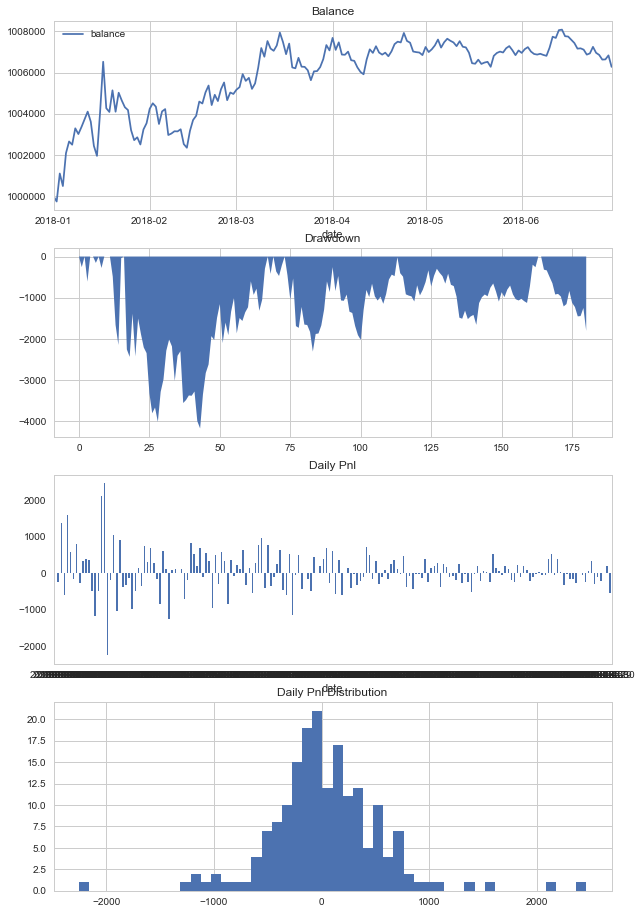

2018-07-14 14:11:54.355006	计算回测结果
2018-07-14 14:11:54.360000	------------------------------
2018-07-14 14:11:54.360000	第一笔交易：	2018-01-08 10:01:00
2018-07-14 14:11:54.360000	最后一笔交易：	2018-06-30 23:59:00
2018-07-14 14:11:54.360000	总交易次数：	63
2018-07-14 14:11:54.360000	总盈亏：	6,271.62
2018-07-14 14:11:54.360000	最大回撤: 	-2,183.19
2018-07-14 14:11:54.360000	平均每笔盈利：	99.55
2018-07-14 14:11:54.360000	平均每笔滑点：	0.4
2018-07-14 14:11:54.360000	平均每笔佣金：	17.65
2018-07-14 14:11:54.360000	胜率		36.51%
2018-07-14 14:11:54.360000	盈利交易平均值	858.86
2018-07-14 14:11:54.360000	亏损交易平均值	-337.06
2018-07-14 14:11:54.360000	盈亏比：	2.55


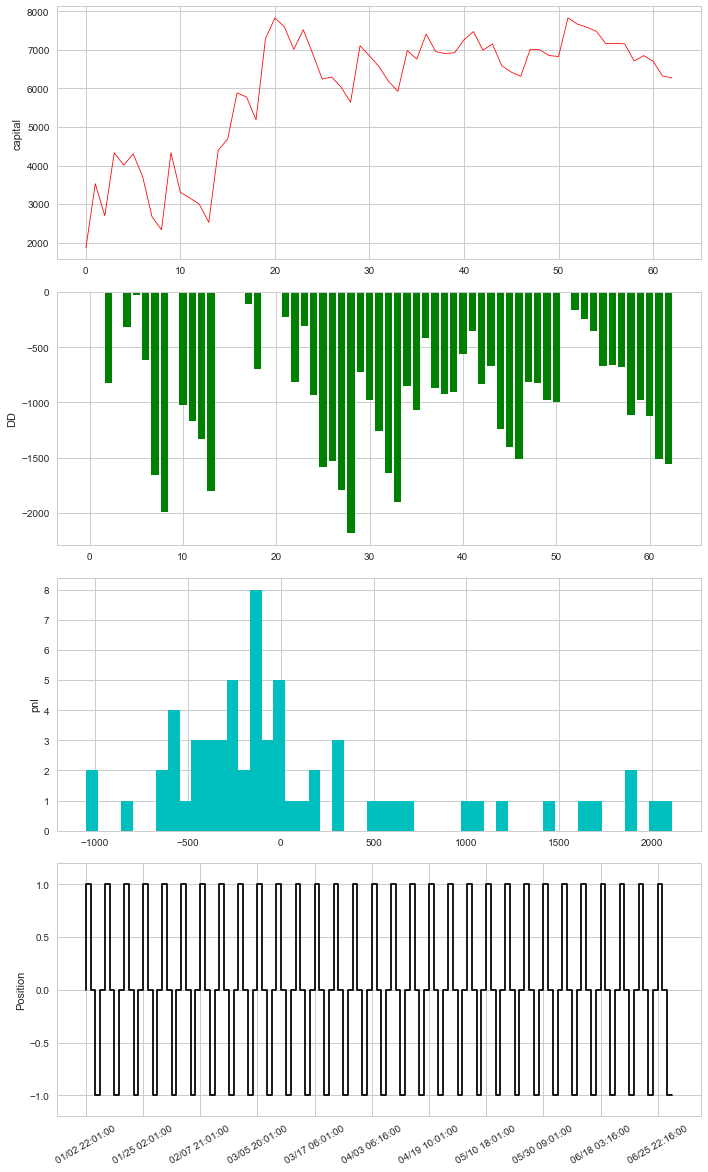

In [10]:
# 显示逐日回测结果
engine.showDailyResult()
# 显示逐笔回测结果
engine.showBacktestingResult()

In [11]:
PerfromanceDf = engine.calculateDailyResult()

2018-07-14 14:12:08.327739	计算按日统计结果


In [12]:
PerfromanceDf.to_excel('perfromanceMultiFrameMa.xlsx')

In [13]:
df1, result = engine.calculateDailyStatistics(PerfromanceDf)

In [14]:
result

{'annualizedReturn': 0.8324685069686438,
 'dailyCommission': 6.106418059031269,
 'dailyNetPnl': 34.68618779036102,
 'dailyReturn': 0.003457775797119628,
 'dailySlippage': 0.13812154696132586,
 'dailyTradeCount': 0.6906077348066298,
 'dailyTurnover': 6106.418059031271,
 'endBalance': 1006278.1999900553,
 'endDate': datetime.date(2018, 6, 30),
 'lossDays': 93,
 'maxDdPercent': -0.4146558015332008,
 'maxDrawdown': -4173.618200000026,
 'profitDays': 87,
 'returnStd': 0.0531376335447008,
 'sharpeRatio': 1.0080921699983318,
 'startDate': datetime.date(2018, 1, 1),
 'totalCommission': 1105.2616686846598,
 'totalDays': 181,
 'totalNetPnl': 6278.199990055345,
 'totalReturn': 0.6278199990055189,
 'totalSlippage': 24.999999999999982,
 'totalTradeCount': 125,
 'totalTurnover': 1105261.66868466}

In [15]:
# 优化配置
setting = OptimizationSetting()                 # 新建一个优化任务设置对象
setting.setOptimizeTarget('totalNetPnl')        # 设置优化排序的目标是策略净盈利
setting.addParameter('fastWindow', 30, 50, 10)    # 增加第一个优化参数atrLength，起始12，结束20，步进2
setting.addParameter('slowWindow', 70, 90, 10)        # 增加第二个优化参数atrMa，起始20，结束30，步进5
setting.addParameter('symbolList', ['tBTCUSD:bitfinex']) 
#setting.addParameter('rsiLength', 5)            # 增加一个固定数值的参数

# 执行多进程优化
import time
start = time.time()
# resultList = engine.runParallelOptimization(MultiFrameMaStrategy, setting)
resultList = engine.runOptimization(MultiFrameMaStrategy, setting)
print('耗时：%s' %(time.time()-start))

2018-07-14 14:12:22.261496	------------------------------
2018-07-14 14:12:22.261496	setting: {'fastWindow': 30, 'slowWindow': 70, 'symbolList': ['tBTCUSD:bitfinex']}
2018-07-14 14:12:22.261496	开始回测
2018-07-14 14:12:22.261496	策略初始化
2018-07-14 14:12:22.262494	载入历史数据。数据范围:[20171231,20180101)
2018-07-14 14:12:22.398355	载入完成，数据量：1414
2018-07-14 14:12:22.410343	策略初始化完成
2018-07-14 14:12:22.410343	策略启动完成
2018-07-14 14:12:22.410343	开始回放回测数据,回测范围:[20180101,20180701)
2018-07-14 14:12:22.411342	载入历史数据。数据范围:[20180101,20180311)
2018-07-14 14:12:30.987588	载入完成，数据量：99357
2018-07-14 14:12:30.987588	当前回放数据:[20180101,20180311)
2018-07-14 14:12:32.390154	载入历史数据。数据范围:[20180311,20180519)
2018-07-14 14:12:40.869498	载入完成，数据量：99073
2018-07-14 14:12:40.905462	当前回放数据:[20180311,20180519)
2018-07-14 14:12:42.354982	载入历史数据。数据范围:[20180519,20180701)
2018-07-14 14:12:47.503724	载入完成，数据量：61359
2018-07-14 14:12:47.551675	当前回放数据:[20180519,20180701)
2018-07-14 14:12:48.389818	数据回放结束ss: 100%    
2018-07-14 14:12:48.389818	

2018-07-14 14:15:46.757710	载入完成，数据量：1414
2018-07-14 14:15:46.782684	策略初始化完成
2018-07-14 14:15:46.782684	策略启动完成
2018-07-14 14:15:46.782684	开始回放回测数据,回测范围:[20180101,20180701)
2018-07-14 14:15:46.783683	载入历史数据。数据范围:[20180101,20180311)
2018-07-14 14:15:55.048245	载入完成，数据量：99357
2018-07-14 14:15:55.049245	当前回放数据:[20180101,20180311)
2018-07-14 14:15:56.429834	载入历史数据。数据范围:[20180311,20180519)
2018-07-14 14:16:04.437659	载入完成，数据量：99073
2018-07-14 14:16:04.477618	当前回放数据:[20180311,20180519)
2018-07-14 14:16:05.943121	载入历史数据。数据范围:[20180519,20180701)
2018-07-14 14:16:10.850112	载入完成，数据量：61359
2018-07-14 14:16:10.883077	当前回放数据:[20180519,20180701)
2018-07-14 14:16:11.774169	数据回放结束ss: 100%    
2018-07-14 14:16:11.774169	计算按日统计结果
2018-07-14 14:16:11.795146	------------------------------
2018-07-14 14:16:11.795146	优化结果：
2018-07-14 14:16:11.795146	参数：["{'fastWindow': 40, 'slowWindow': 70, 'symbolList': ['tBTCUSD:bitfinex']}"]，目标：10680.548199999987
2018-07-14 14:16:11.795146	参数：["{'fastWindow': 30, 'slowWindow

In [16]:
resultList

[(["{'fastWindow': 40, 'slowWindow': 70, 'symbolList': ['tBTCUSD:bitfinex']}"],
  10680.548199999987,
  {'annualizedReturn': 1.4162052861878272,
   'dailyCommission': 4.70691602209945,
   'dailyNetPnl': 59.008553591160144,
   'dailyReturn': 0.0058695657702081214,
   'dailySlippage': 0.10497237569060773,
   'dailyTradeCount': 0.5248618784530387,
   'dailyTurnover': 4706.916022099448,
   'endBalance': 1010680.5482,
   'endDate': datetime.date(2018, 6, 30),
   'lossDays': 80,
   'maxDdPercent': -0.32755057808384364,
   'maxDrawdown': -3293.680000000051,
   'profitDays': 99,
   'returnStd': 0.052348857560623414,
   'sharpeRatio': 1.737018268347818,
   'startDate': datetime.date(2018, 1, 1),
   'totalCommission': 851.9518000000004,
   'totalDays': 181,
   'totalNetPnl': 10680.548199999987,
   'totalReturn': 1.0680548199999862,
   'totalSlippage': 19.0,
   'totalTradeCount': 95,
   'totalTurnover': 851951.8000000002}),
 (["{'fastWindow': 30, 'slowWindow': 80, 'symbolList': ['tBTCUSD:bitfinex

In [17]:
import pandas as pd

print(pd.DataFrame(resultList).sort_values(1,  ascending=False).iloc[0:5])

                                                   0             1  \
0  [{'fastWindow': 40, 'slowWindow': 70, 'symbolL...  10680.548200   
1  [{'fastWindow': 30, 'slowWindow': 80, 'symbolL...   7708.987242   
2  [{'fastWindow': 50, 'slowWindow': 70, 'symbolL...   7373.351579   
3  [{'fastWindow': 30, 'slowWindow': 90, 'symbolL...   5944.007184   
4  [{'fastWindow': 30, 'slowWindow': 70, 'symbolL...   5036.003355   

                                                   2  
0  {'startDate': 2018-01-01, 'endDate': 2018-06-3...  
1  {'startDate': 2018-01-01, 'endDate': 2018-06-3...  
2  {'startDate': 2018-01-01, 'endDate': 2018-06-3...  
3  {'startDate': 2018-01-01, 'endDate': 2018-06-3...  
4  {'startDate': 2018-01-01, 'endDate': 2018-06-3...  


In [18]:
# 显示优化的所有统计数据
for result in resultList:
    print('-' * 30)
    print('参数：%s，目标：%s' %(result[0], result[1]))
    print('统计数据：')
    for k, v in result[2].items():
        print('%s：%s' %(k, v))

------------------------------
参数：["{'fastWindow': 40, 'slowWindow': 70, 'symbolList': ['tBTCUSD:bitfinex']}"]，目标：10680.548199999987
统计数据：
startDate：2018-01-01
endDate：2018-06-30
totalDays：181
profitDays：99
lossDays：80
endBalance：1010680.5482
maxDrawdown：-3293.680000000051
maxDdPercent：-0.32755057808384364
totalNetPnl：10680.548199999987
dailyNetPnl：59.008553591160144
totalCommission：851.9518000000004
dailyCommission：4.70691602209945
totalSlippage：19.0
dailySlippage：0.10497237569060773
totalTurnover：851951.8000000002
dailyTurnover：4706.916022099448
totalTradeCount：95
dailyTradeCount：0.5248618784530387
totalReturn：1.0680548199999862
annualizedReturn：1.4162052861878272
dailyReturn：0.0058695657702081214
returnStd：0.052348857560623414
sharpeRatio：1.737018268347818
------------------------------
参数：["{'fastWindow': 30, 'slowWindow': 80, 'symbolList': ['tBTCUSD:bitfinex']}"]，目标：7708.987241559517
统计数据：
startDate：2018-01-01
endDate：2018-06-30
totalDays：181
profitDays：93
lossDays：86
endBalance：1